<a href="https://colab.research.google.com/github/talbaram3192/Emotion_Recognition/blob/master/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount google drive

In [5]:
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
main_path = '/gdrive/MyDrive/Projects/ITCproject/'

## Import

In [ ]:
# !pip install livelossplot

In [3]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

## Functions

### Saving files and logging

In [6]:
def namestr(obj, namespace=globals()):
  return [name for name in namespace if namespace[name] is obj]


def save_pickle(obj, path='/gdrive/MyDrive/Projects/ITCproject/backup/'):
  """
  The function generates filename and saves the file as a pickle object
  """
  dt = datetime.now().strftime("_%d.%m_%H:%M:%S")
  filename = namestr(obj)[0] + dt + '.pickle'
  
  try:
    pickle.dump(obj, open(os.path.join(path, filename), "wb" ))
    save_path = os.path.join(path, filename)
  except:
    pickle.dump(obj, open(filename, "wb" ))
    save_path = filename

  print(f'File was saved as \"{filename}\"')
  return save_path

### Features extracting

1. Signal speed scaling by a random number in [1.5, 4.0] (done).
2. Pitch shift by a random number (to do).
3. Volume increase/decrease by a random number (to do).
4. Addition of random uniform noise (done).
5. Time shift (done).

In [103]:
def get_audio_data(path, calculate_db=False, calculate_mfccs=False, 
                   add_noize=False, add_speed=False, add_shift=False,
                   plots=False):
  """
  Get all data from the audio file
  """
  data, sampling_rate = librosa.load(path, sr=44100)
  Xdb = None

  # add white noise
  if add_noize: 
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])

  # increase speed
  if add_speed: 
    data = data * np.random.uniform(low=1.5,high=4)

  # add shift
  if add_shift:
    start_ = int(np.random.uniform(-4800,4800))
    if start_ >= 0:
      data = np.r_[data[start_:], np.random.uniform(-0.001,0.001, start_)]
    else:
      data = np.r_[np.random.uniform(-0.001,0.001, -start_), data[:start_]]

  if calculate_db:
      X = librosa.stft(data)
      Xdb = librosa.amplitude_to_db(abs(X))
  mfccs = None

  if calculate_mfccs:
      mfccs = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc = 40)
  
  if calculate_db and plots:
      fig, ax = plt.subplots(1,2,figsize=(16, 3))
      plt.subplot(121)
      librosa.display.waveplot(data, sr=sampling_rate)
      plt.subplot(122)
      librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
      plt.show()
  elif plots:
      librosa.display.waveplot(data, sr=sampling_rate)

  return (data, Xdb, mfccs)

### Preprocessing

In [8]:
def pad_array(a, limit):
  assert len(a.shape) == 2
  new_a = a

  if a.shape[1] < limit:
    a_shape = a.shape[1]
    new_a = np.zeros((a.shape[0], limit))
    new_a[:, :a.shape[1]] = a

  elif a.shape[1] > limit:
    new_a = a[:,:limit]

  return new_a

def cut_array(a, limit):
  assert len(a.shape) == 2
  if a.shape[1] > limit:
    a = a[:,:limit]
  return a

def transform_mfccs(arr, transform='pad'):
  list_lengths = [x.shape[1] for x in arr]

  if transform == 'pad':
    limit = int(np.median(list_lengths)) # average length of array
    new_arr = [pad_array(a, limit) for a in arr]
  elif transform == 'cut':
    limit = np.min(list_lengths) # mimimal length of array
    new_arr = [cut_array(a, limit) for a in arr]
  else:
    print("wrong parameter for the transformation")
    return

  new_arr = np.array(new_arr)
  return new_arr

### Reporting

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def report_res_and_plot_matrix(y_test, y_pred, plot_classes):

  #report metrics
  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}")
  # print(f"Classes: {plot_classes}")

  #plot matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
    
  tick_marks = np.arange(len(plot_classes))
  plt.xticks(ticks=tick_marks, labels=plot_classes, rotation=90)
  plt.yticks(ticks=tick_marks, labels=plot_classes, rotation=90)

  group_counts = [f'{value:0.0f}' for value in cnf_matrix.flatten()]
  group_percentages = [f'{100 * value:0.1f} %' for value in 
                       cnf_matrix.flatten()/np.sum(cnf_matrix)]
  labels = [f'{v1}\n({v2})' for v1, v2 in
            zip(group_counts,group_percentages)]
  n = int(np.sqrt(len(labels)))
  labels = np.asarray(labels).reshape(n,n)
  sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  # return metrics
  return [acc, cnf_matrix]

# Classes

### Features extracting

In [104]:
class DatasetSelector:
  def __init__(self, df, label='emotion2', src='source', path='path', 
               subclass='actors'):
    """
    Format: df.columns = [label, source, actors, path]
    """
    self.df = df
    self.label = label
    self.path = path
    self.subclass = subclass
    self.src = src

  def select(self, source=None, subclass=None, balanced=True, verbose=False):
    """
    The function selects files from the dataset by parameters and returns df
    source: list of sources ["TESS", "SAVEE", "RAV", "CREMA"], by default - all
    subclass: name of subclass, by default - all
    balanced: True/False - if needed to balance classes or not
    """
    df = self.df

    if not source is None:
      df = df.loc[(df[self.src].isin(source))]

    if not subclass is None:
      df = df.loc[(df[self.subclass]==subclass)]

    if balanced:
      label_counts = df[self.label].value_counts().values
      label_names = df[self.label].value_counts().index
      balanced = np.min(label_counts)

      sub_df_list =[]
      for lab in df[self.label].unique():
        sub_df = df.loc[(df[self.label]==lab)]
        sub_df_list.append(sub_df.sample(balanced))

      df = pd.concat(sub_df_list)

    print(f"New shape: {df.shape}") 
    if balanced and verbose:
      print(df[self.label].value_counts())  

    return df
  
  def load_mfccs(self, source=None, subclass=None, balanced=True, 
                 with_noise=False, with_shift=False, with_speed=False):
    """
    The function returns array of mfccs and labels for selected df
    """
    df = self.select(source, subclass, balanced, verbose=True)
    arr_mfccs = []
    
    print("Extracting of mfccs from the data...")
    for path in tqdm(df[self.path].values):
      a1, a2, a3 = get_audio_data(path, calculate_mfccs=True, 
                                  add_noize=with_noise, 
                                  add_speed=with_speed, 
                                  add_shift=with_shift)
      arr_mfccs.append(a3)

    return (arr_mfccs, df[self.label].values, df[self.path].values)

  def load_melspecs(self, source=None, subclass=None, balanced=True, 
                    with_noise=False, with_shift=False, with_speed=False):
    """
    The function returns array of mfccs and labels for selected df
    """
    df = self.select(source, subclass, balanced, verbose=True)
    arr_melspec = []
    
    print("Extracting of mel-spectrograms from the data...")
    for path in tqdm(df[self.path].values):
      a1, a2, a3 = get_audio_data(path, calculate_db=True, 
                                  add_noize=with_noise, 
                                  add_speed=with_speed, 
                                  add_shift=with_shift)
      arr_melspec.append(a2)

    print("Converting of mel-spectrograms to images...")
    arr_melspec_images = []
    for a in tqdm(arr_melspec):
      img = np.stack((a,) * 3,-1)
      img = img.astype(np.uint8)
      grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      grayImage = cv2.resize(grayImage, (224, 224))
      arr_melspec_images.append(grayImage)
    
    arr_melspec_images = np.array(arr_melspec_images)

    print("All mel-spectrograms were converted successfully")
    print(arr_melspec_images[:][:][0].shape)
    # plt.imshow(grayImage)

    return (arr_melspec_images, df[self.label].values, df[self.path].values)

# Load files

In [11]:
path0 = os.path.join(main_path, 'combined_all4.csv')

df_combined = pd.read_csv(path0)
df_combined.head()

,emotion_label,source,actors,path,emotion2,emotion3,id
0,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female,0
1,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female,1
2,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female,2
3,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female,3
4,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female,4


In [105]:
ds = DatasetSelector(df_combined)

# BASELINE CNN MODEL FOR MFCCS

# Model architecture

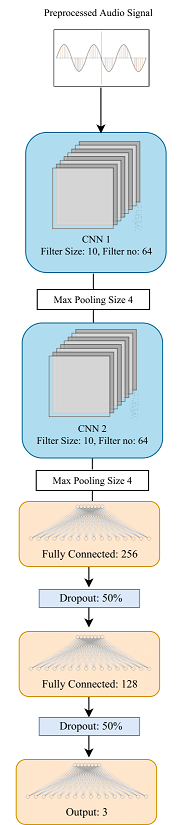

# CNN for female voice

## Data preparation

In [61]:
X, y, check_ = ds.load_mfccs(subclass='female', source=['TESS','RAV'], balanced=False)

New shape: (3520, 7)


In [62]:
X = transform_mfccs(X)

In [63]:
save_pickle(X)
save_pickle(y)

File was saved as "X_17.02_11:15:04.pickle"
File was saved as "y_17.02_11:15:06.pickle"


'/gdrive/MyDrive/Projects/ITCproject/backup/y_17.02_11:15:06.pickle'

In [ ]:
# LOG

# all datasets - balanced
# File was saved as "X_17.02_10:55:25.pickle"
# File was saved as "y_17.02_10:55:27.pickle"

# RAV & TESS - unbalanced
# File was saved as "X_17.02_11:15:04.pickle"
# File was saved as "y_17.02_11:15:06.pickle"

In [20]:
selected_path = main_path+'backup/'

X_filename = 'X_17.02_11:15:04.pickle'
y_filename = 'y_17.02_11:15:06.pickle'

with open(selected_path + X_filename, 'rb') as picklefile:
  X = pickle.load(picklefile)
with open(selected_path + y_filename, 'rb') as picklefile:
  y = pickle.load(picklefile)

## Train and test splitting

In [21]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2816, 40, 186), (704, 40, 186), (2816,), (704,))

In [22]:
# vectorize labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['negative_female', 'neutral_female', 'positive_female'],
      dtype=object)

## Model

In [23]:
# build base model1 for mfccs
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(3))
model.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'female_model_weights.hdf5'), 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

model.compile(optimizer=Adam(lr=0.0006), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            119104    
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            41024     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)           

In [24]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a 
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a

class_weight = {0: a0, 1: a1, 2: a2}

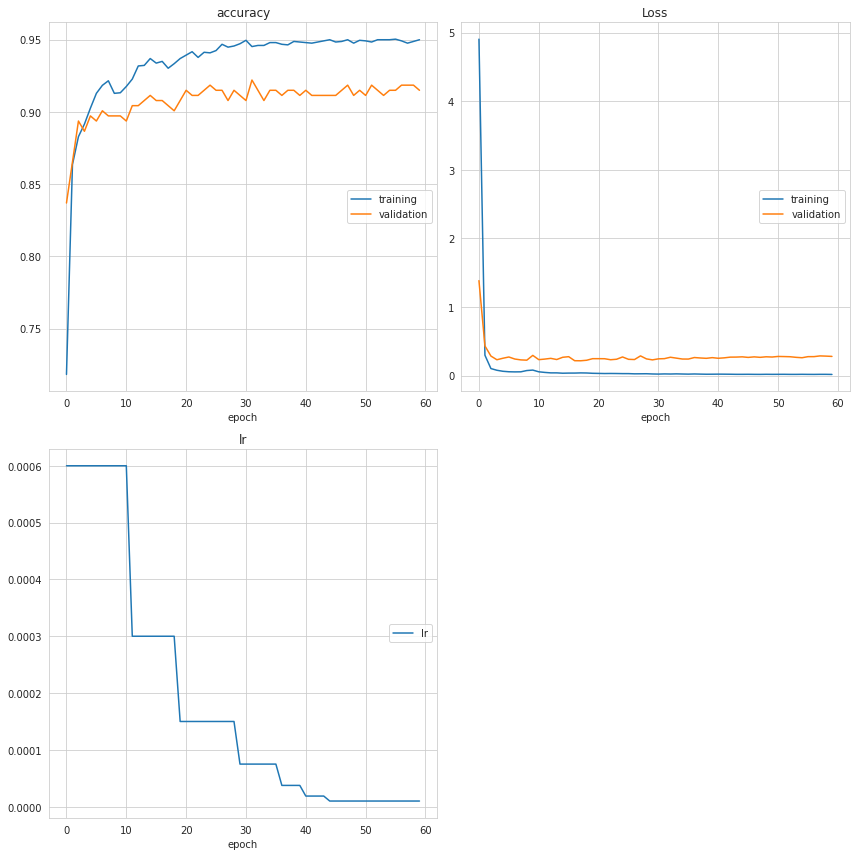

accuracy
	training         	 (min:    0.718, max:    0.950, cur:    0.950)
	validation       	 (min:    0.837, max:    0.922, cur:    0.915)
Loss
	training         	 (min:    0.017, max:    4.905, cur:    0.017)
	validation       	 (min:    0.216, max:    1.384, cur:    0.280)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
Epoch 00060: early stopping


In [25]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.1, 
                    callbacks=[early_stop, model_checkpoint, reduce_lr, PlotLossesKeras()],
                    class_weight=class_weight)

In [29]:
# model.save(os.path.join(main_path,'backup/cnnmodel_female_TESS_RAV_unbalanced.h5'))

                 precision    recall  f1-score   support

negative_female       0.90      0.97      0.93       397
 neutral_female       1.00      0.78      0.88       109
positive_female       0.93      0.88      0.90       198

       accuracy                           0.92       704
      macro avg       0.94      0.88      0.90       704
   weighted avg       0.92      0.92      0.92       704

Accuracy: 0.9162


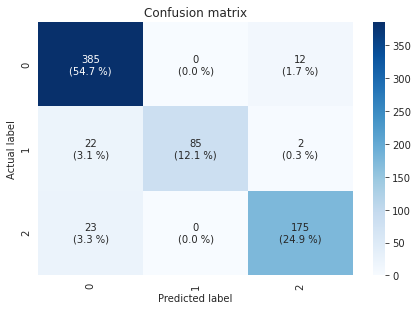

In [27]:
# model.load_weights(os.path.join(main_path,'female_model_weights.hdf5'))
y_pred = model.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))
params = report_res_and_plot_matrix(y_test, y_pred, le.classes_)

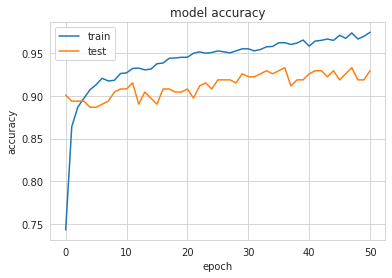

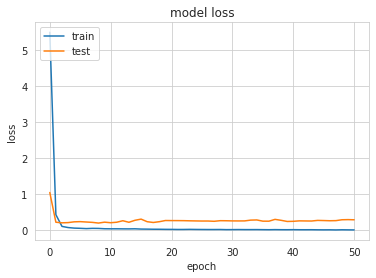

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN for male voice

## Data preparation

In [106]:
X, y, check_ = ds.load_mfccs(subclass='male', balanced=True, with_noise=True)

New shape: (2517, 7)
negative_male    839
positive_male    839
neutral_male     839
Name: emotion2, dtype: int64
Extracting of mfccs from the data...


In [107]:
X = transform_mfccs(X)

In [108]:
save_pickle(X)
save_pickle(y)

File was saved as "X_17.02_13:56:56.pickle"
File was saved as "y_17.02_13:56:58.pickle"


'/gdrive/MyDrive/Projects/ITCproject/backup/y_17.02_13:56:58.pickle'

In [ ]:
# LOG

# all datasets - balanced
# File was saved as "X_17.02_11:59:07.pickle"
# File was saved as "y_17.02_11:59:08.pickle"

# all datasets - balanced with noise
# File was saved as "X_17.02_13:56:56.pickle"
# File was saved as "y_17.02_13:56:58.pickle"

# RAV & SAVEE - balanced
# File was saved as "X_17.02_11:39:15.pickle"
# File was saved as "y_17.02_11:39:15.pickle"

In [ ]:
selected_path = main_path+'backup/'

X_filename = 'X_17.02_11:39:15.pickle'
y_filename = 'y_17.02_11:39:15.pickle'

with open(selected_path + X_filename, 'rb') as picklefile:
  X = pickle.load(picklefile)
with open(selected_path + y_filename, 'rb') as picklefile:
  y = pickle.load(picklefile)

## Train and test splitting

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2013, 40, 225), (504, 40, 225), (2013,), (504,))

In [110]:
# Our vectorized labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['negative_male', 'neutral_male', 'positive_male'], dtype=object)

## Model

In [131]:
# build base model1 for mfccs
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.3))##############
model2.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model2.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.001))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(128))############
# model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.Dense(64))###########
# model2.add(tf.keras.layers.Dropout(0.1))

model2.add(tf.keras.layers.Dense(3))
model2.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=2, ######
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'male_model_weights.hdf5'), 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

model2.compile(optimizer=Adam(lr=0.0006), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model2.load_weights(os.path.join(main_path,'male_model_weights.hdf5'))
model2.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 40, 64)            144064    
_________________________________________________________________
activation_63 (Activation)   (None, 40, 64)            0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 10, 64)            41024     
_________________________________________________________________
activation_64 (Activation)   (None, 10, 64)            0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 10, 64)          

In [51]:
model2.input_shape, model2.output_shape

((None, 40, 222), (None, 3))

In [112]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a 
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a

# a3 = len(np.where(a == 3)[0])/len_a 
# a4 = len(np.where(a == 4)[0])/len_a
# a5 = len(np.where(a == 5)[0])/len_a

class_weight = {0: a0, 1: a1, 2: a2} #, 3: a3, 4: a4, 5: a5}

In [132]:
history2 = model2.fit(X_train, y_train, batch_size=18, epochs=500, validation_split=0.1, 
                    callbacks=[early_stop, model_checkpoint, reduce_lr],
                    class_weight=class_weight)

Epoch 1/500
101/101 [==============================] - 3s 22ms/step - loss: 19.3519 - accuracy: 0.3526 - val_loss: 13.9679 - val_accuracy: 0.4307
Epoch 2/500
101/101 [==============================] - 2s 19ms/step - loss: 3.6457 - accuracy: 0.4416 - val_loss: 4.3094 - val_accuracy: 0.4208
Epoch 3/500
101/101 [==============================] - 2s 19ms/step - loss: 1.0280 - accuracy: 0.4997 - val_loss: 2.0674 - val_accuracy: 0.4208

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/500
101/101 [==============================] - 2s 19ms/step - loss: 0.5242 - accuracy: 0.5587 - val_loss: 1.2613 - val_accuracy: 0.5099
Epoch 5/500
101/101 [==============================] - 2s 19ms/step - loss: 0.4144 - accuracy: 0.5772 - val_loss: 1.1711 - val_accuracy: 0.4950
Epoch 6/500
101/101 [==============================] - 2s 20ms/step - loss: 0.3483 - accuracy: 0.5797 - val_loss: 1.0477 - val_accuracy: 0.4802

Epoch 00006: ReduceLROnPlateau reducing learning rat

In [87]:
# model.save(os.path.join(main_path,'backup/cnnmodel_male_SAVEE_RAV_unbalanced.h5'))
model.save(os.path.join(main_path,'backup/cnnmodel_male_all_balanced.h5'))

               precision    recall  f1-score   support

negative_male       0.47      0.39      0.43       168
 neutral_male       0.60      0.64      0.62       168
positive_male       0.56      0.61      0.59       168

     accuracy                           0.55       504
    macro avg       0.54      0.55      0.54       504
 weighted avg       0.54      0.55      0.54       504

Accuracy: 0.5496


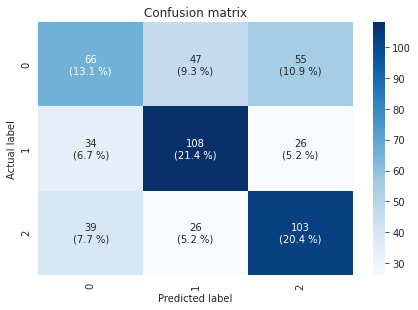

In [134]:
# model2.save_weights(os.path.join(main_path,'male_model_weights.hdf5'), overwrite=True)
model2.load_weights(os.path.join(main_path,'male_model_weights.hdf5'))

y_pred = model2.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))
params2 = report_res_and_plot_matrix(y_test, y_pred, le.classes_)

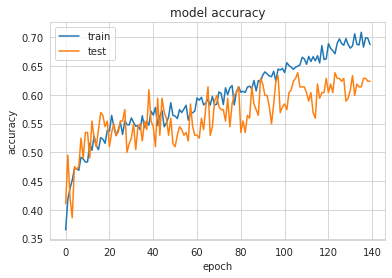

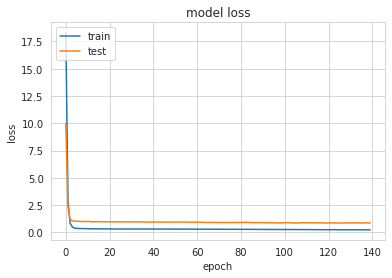

In [79]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# TRANSFER LEARNING FOR MEL-SPECTROGRAMS

# Load the pretrained model

In [23]:
pretrained_model = tf.keras.applications.DenseNet201(include_top=False, 
                                                     weights='imagenet', 
                                                     input_shape=(224,224,3))
# pretrained_model.trainable = False
for layer in pretrained_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

pretrained_model.input_shape, pretrained_model.output_shape

74842112/74836368 [==============================] - 1s 0us/step


((None, 224, 224, 3), (None, 7, 7, 1920))

In [ ]:
# with open(path4, "rb") as f:
#     mel_images = pickle.load(f)
#     print("File loaded")

File loaded


# TL for female voice

In [15]:
X, y, check_ = ds.load_melspecs(subclass='female', source=['TESS','RAV'], balanced=False)

New shape: (3520, 7)
Extracting of mel-spectrograms from the data...



Converting of mel-spectrograms to images...



All mel-spectrograms were converted successfully
(224, 224)


In [16]:
X.shape, y.shape, X[0].shape

((3520, 224, 224), (3520,), (224, 224))

In [17]:
save_pickle(X)
save_pickle(y)

File was saved as "X_17.02_00:01:42.pickle"
File was saved as "y_17.02_00:01:44.pickle"


'/gdrive/MyDrive/Projects/ITCproject/backup/y_17.02_00:01:44.pickle'

['negative_female']


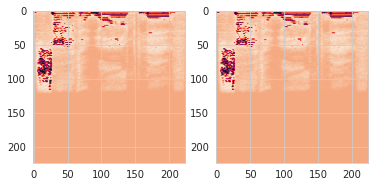

In [18]:
# check selection

rnd = np.random.randint(1, X.shape[0])
path = check_[rnd]
a1, a2, a3 = get_audio_data(path, calculate_db=True)
img = np.stack((a2,) * 3,-1)
img = img.astype(np.uint8)
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
grayImage = cv2.resize(grayImage, (224, 224))
txt = df_combined.loc[df_combined.path==path].emotion2.values
print(txt)

plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(grayImage)
plt.subplot(1,2,2)
plt.imshow(X[rnd])
plt.show()
ipd.Audio(path)

## Train and test splitting

In [19]:
# repeat image three times to get it in RGB format
X = np.repeat(X[..., np.newaxis], 3, -1)
print(X.shape)  # (2517, 224, 224, 3)

(3520, 224, 224, 3)


In [20]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2816, 224, 224, 3), (704, 224, 224, 3), (2816,), (704,))

In [21]:
# vectorize labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['negative_female', 'neutral_female', 'positive_female'],
      dtype=object)

## Model

In [24]:
transfer_model = tf.keras.models.Sequential()
transfer_model.add(pretrained_model)
transfer_model.add(tf.keras.layers.GlobalAveragePooling2D())
transfer_model.add(tf.keras.layers.Flatten())

transfer_model.add(tf.keras.layers.Dense(256))
transfer_model.add(tf.keras.layers.Dropout(0.2))

transfer_model.add(tf.keras.layers.Dense(128))
transfer_model.add(tf.keras.layers.Dropout(0.1))
transfer_model.add(tf.keras.layers.Dense(3, activation='softmax'))
# model.add(tf.keras.layers.Activation('softmax'))

transfer_model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# set callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'weights_.hdf5'), 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [58]:
transfer_model.input_shape, transfer_model.output_shape

((None, 224, 224, 3), (None, 3))

In [25]:
thistory = transfer_model.fit(X_train, y_train, batch_size=16, epochs=500, validation_split=0.1, 
                    callbacks=[early_stop, model_checkpoint, reduce_lr])

Epoch 1/500
159/159 [==============================] - 809s 5s/step - loss: 34.1447 - accuracy: 0.4497 - val_loss: 0.5167 - val_accuracy: 0.7730
Epoch 2/500
159/159 [==============================] - 784s 5s/step - loss: 0.6076 - accuracy: 0.7470 - val_loss: 0.4980 - val_accuracy: 0.8298
Epoch 3/500
159/159 [==============================] - 785s 5s/step - loss: 0.4232 - accuracy: 0.8485 - val_loss: 0.6026 - val_accuracy: 0.8369
Epoch 4/500
159/159 [==============================] - 786s 5s/step - loss: 0.2988 - accuracy: 0.8960 - val_loss: 0.2430 - val_accuracy: 0.9078
Epoch 5/500
159/159 [==============================] - 787s 5s/step - loss: 0.2933 - accuracy: 0.8882 - val_loss: 0.2549 - val_accuracy: 0.9149
Epoch 6/500
159/159 [==============================] - 786s 5s/step - loss: 0.3742 - accuracy: 0.8774 - val_loss: 0.2344 - val_accuracy: 0.9007
Epoch 7/500
159/159 [==============================] - 787s 5s/step - loss: 0.2948 - accuracy: 0.8997 - val_loss: 0.3334 - val_accuracy

In [27]:
# transfer_model.save(os.path.join(main_path,'/backup/tmodel_female_RAV_TESS_unbalanced.h5'))

                 precision    recall  f1-score   support

negative_female       0.93      0.94      0.93       395
 neutral_female       0.88      0.95      0.91       105
positive_female       0.94      0.88      0.91       204

       accuracy                           0.92       704
      macro avg       0.92      0.92      0.92       704
   weighted avg       0.93      0.92      0.92       704

Accuracy: 0.9247


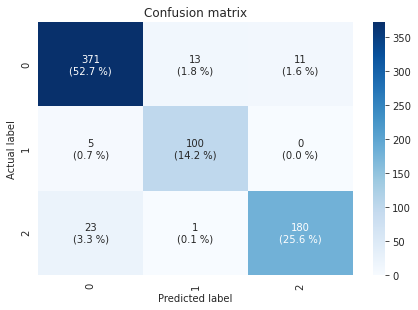

In [28]:
# transfer_model.load_weights('weights.hdf5')
transfer_model.load_weights(os.path.join(main_path,'weights_.hdf5'))

y_pred = transfer_model.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))
tparams = report_res_and_plot_matrix(y_test, y_pred, le.classes_)

In [29]:
y_pred.shape, np.array(y_test).shape, X_test.shape

((704,), (704,), (704, 224, 224, 3))

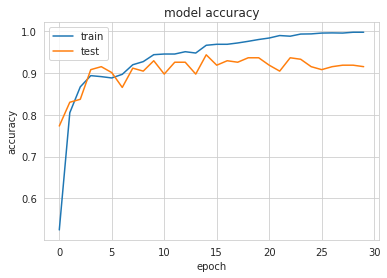

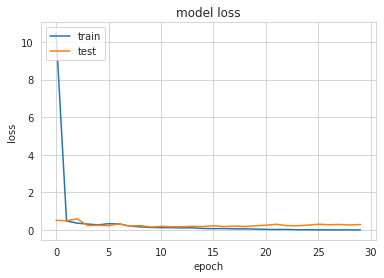

In [46]:
# summarize history for accuracy
plt.plot(thistory.history['accuracy'])
plt.plot(thistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(thistory.history['loss'])
plt.plot(thistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# TL for male voice

In [31]:
X, y, check_ = ds.load_melspecs(subclass='male', source=['SAVEE','RAV'], balanced=False)

New shape: (720, 7)
Extracting of mel-spectrograms from the data...



Converting of mel-spectrograms to images...



All mel-spectrograms were converted successfully
(224, 224)


In [32]:
X.shape, y.shape, X[0].shape

((720, 224, 224), (720,), (224, 224))

In [33]:
save_pickle(X)
save_pickle(y)

File was saved as "X_17.02_07:11:29.pickle"
File was saved as "y_17.02_07:11:29.pickle"


'/gdrive/MyDrive/Projects/ITCproject/backup/y_17.02_07:11:29.pickle'

['neutral_male']


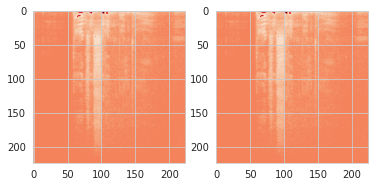

In [34]:
# check selection

rnd = np.random.randint(1, X.shape[0])
path = check_[rnd]
a1, a2, a3 = get_audio_data(path, calculate_db=True)
img = np.stack((a2,) * 3,-1)
img = img.astype(np.uint8)
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
grayImage = cv2.resize(grayImage, (224, 224))
txt = df_combined.loc[df_combined.path==path].emotion2.values
print(txt)

plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(grayImage)
plt.subplot(1,2,2)
plt.imshow(X[rnd])
plt.show()
ipd.Audio(path)

## Train and test splitting

In [35]:
# repeat image three times to get it in RGB format
X = np.repeat(X[..., np.newaxis], 3, -1)
print(X.shape)  # (2517, 224, 224, 3)

(720, 224, 224, 3)


In [36]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((576, 224, 224, 3), (144, 224, 224, 3), (576,), (144,))

In [37]:
# vectorize labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['negative_male', 'neutral_male', 'positive_male'], dtype=object)

## Model

In [38]:
transfer_model2 = tf.keras.models.Sequential()
transfer_model2.add(pretrained_model)
transfer_model2.add(tf.keras.layers.GlobalAveragePooling2D())
transfer_model2.add(tf.keras.layers.Flatten())

transfer_model2.add(tf.keras.layers.Dense(256))
transfer_model2.add(tf.keras.layers.Dropout(0.2))

transfer_model2.add(tf.keras.layers.Dense(128))
transfer_model2.add(tf.keras.layers.Dropout(0.1))
transfer_model2.add(tf.keras.layers.Dense(3, activation='softmax'))
# model.add(tf.keras.layers.Activation('softmax'))

transfer_model2.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# set callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                              verbose=1)

model_checkpoint_tfm = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'weights_m.hdf5'), 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

transfer_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               491776    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [39]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a 
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a

class_weight = {0: a0, 1: a1, 2: a2}

In [41]:
thistory2 = transfer_model2.fit(X_train, y_train, batch_size=16, epochs=500, 
                                validation_split=0.1, class_weight=class_weight,
                                callbacks=[early_stop, model_checkpoint_tfm, 
                                                                 reduce_lr])

Epoch 1/500
33/33 [==============================] - 166s 5s/step - loss: 0.0165 - accuracy: 0.9768 - val_loss: 2.4623 - val_accuracy: 0.5000
Epoch 2/500
33/33 [==============================] - 165s 5s/step - loss: 0.0146 - accuracy: 0.9884 - val_loss: 2.4363 - val_accuracy: 0.5000
Epoch 3/500
33/33 [==============================] - 165s 5s/step - loss: 0.0166 - accuracy: 0.9788 - val_loss: 2.4940 - val_accuracy: 0.5000
Epoch 4/500
33/33 [==============================] - 166s 5s/step - loss: 0.0155 - accuracy: 0.9846 - val_loss: 2.5811 - val_accuracy: 0.5000
Epoch 5/500
33/33 [==============================] - 165s 5s/step - loss: 0.0142 - accuracy: 0.9865 - val_loss: 2.5894 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 6/500
33/33 [==============================] - 165s 5s/step - loss: 0.0137 - accuracy: 0.9826 - val_loss: 2.6030 - val_accuracy: 0.5000
Epoch 7/500
33/33 [==============================] - 164s 5s/step 

In [43]:
transfer_model.save(os.path.join(main_path,'/backup/tmodel_male_RAV_unbalanced.h5'))

               precision    recall  f1-score   support

negative_male       0.67      0.73      0.70        73
 neutral_male       0.78      0.60      0.68        35
positive_male       0.53      0.56      0.54        36

     accuracy                           0.65       144
    macro avg       0.66      0.63      0.64       144
 weighted avg       0.66      0.65      0.65       144

Accuracy: 0.6528


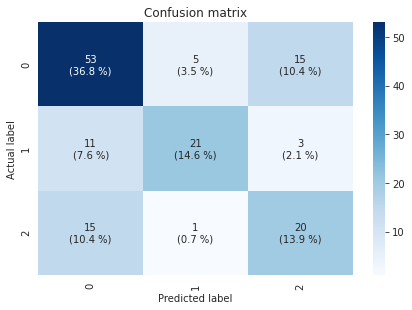

In [42]:
# transfer_model2.load_weights('weights_m.hdf5')
# transfer_model2.load_weights(os.path.join(main_path,'weights_m.hdf5'))

y_pred = transfer_model2.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))
tparams = report_res_and_plot_matrix(y_test, y_pred, le.classes_)

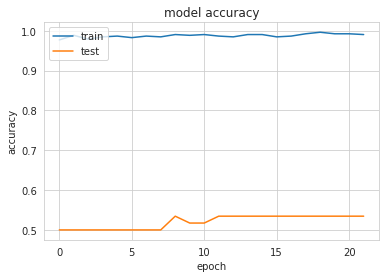

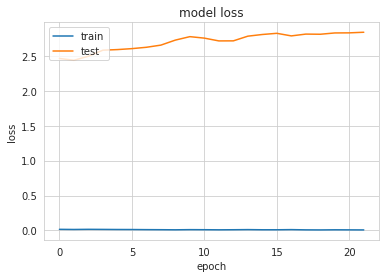

In [45]:
# summarize history for accuracy
plt.plot(thistory2.history['accuracy'])
plt.plot(thistory2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(thistory2.history['loss'])
plt.plot(thistory2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()